In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import PolynomialFeatures,scale

import pymc3 as pm
#import seaborn as sns; sns.set()
from scipy import stats, optimize
from sklearn.datasets import load_diabetes
from sklearn.cross_validation import train_test_split
from theano import shared

c:\users\harpreet singh\appdata\local\programs\python\python36-64\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\users\harpreet singh\appdata\local\programs\python\python36-64\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for 

In [3]:
#UPDATED
df = pd.read_csv('forestfires.csv')
df.drop(['X','Y','month','day',],1,inplace=True)

#Inputs and Output
X = scale(np.array(df.drop(['area'],1)))
y = np.array(df.area.apply(lambda x: np.log(x+1)))

np.random.seed(9)

#Split Data
X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2, random_state=42)

#Preprocess data for Modeling
model_input= shared(X_tr)
model_output= shared(y_tr)

In [4]:
#Generate Model
linear_model = pm.Model()
with linear_model:
    # Priors for unknown model parameters    

    alpha = pm.Normal("alpha", mu=0,sd=1)
    betas = pm.Normal("betas", mu=0, sd=1, shape=X.shape[1])
    sigma = pm.HalfNormal("sigma", tau=1) # you could also try with a HalfCauchy that has longer/fatter tails
    # Expected value of outcome

    mu = alpha + pm.math.dot(betas, model_input.T)
    # Likelihood (sampling distribution of observations)


    y = pm.Normal("y", mu=mu, sd=sigma, observed=model_output)
    # Obtain starting values via Maximum A Posteriori Estimate


In [6]:
#infering parameters
with linear_model:
    inference=pm.ADVI()
    approx = pm.fit(n=5000,more_replacements={
        model_input:pm.Minibatch(X_tr),model_output:pm.Minibatch(y_tr)})


Average Loss = 308: 100%|██████████████████████████████████████████████████████████| 5000/5000 [05:20<00:00, 15.60it/s]
Finished [100%]: Average Loss = 308.22


              mean        sd  mc_error   hpd_2.5  hpd_97.5
alpha     0.848644  0.426326  0.001796  0.000555  1.669831
betas__0  0.028241  0.403353  0.002045 -0.738712  0.843059
betas__1  0.092728  0.411708  0.001847 -0.708370  0.904460
betas__2  0.036272  0.408200  0.002003 -0.766679  0.834515
betas__3 -0.106119  0.422439  0.001672 -0.943129  0.708686
betas__4  0.014673  0.410735  0.001867 -0.792239  0.818074
betas__5 -0.001106  0.379226  0.001692 -0.730284  0.751841
betas__6  0.069750  0.365209  0.001530 -0.659194  0.778856
betas__7 -0.024458  0.454443  0.001974 -0.920143  0.866293
sigma     1.987925  0.795620  0.003532  0.694987  3.552718


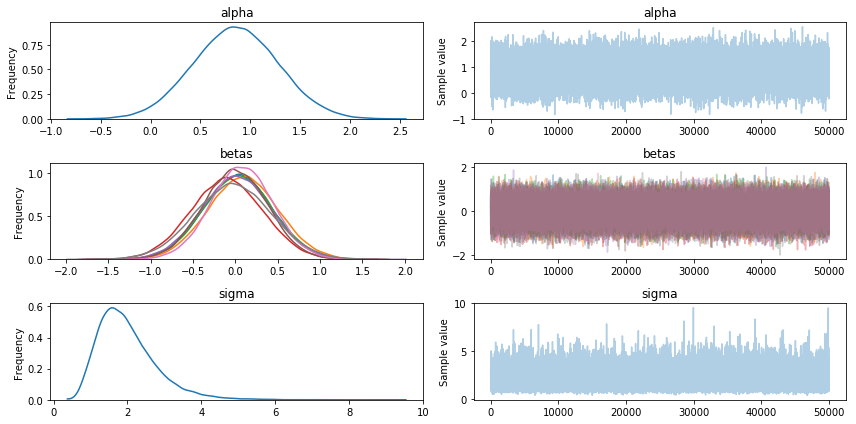

In [13]:
##plt.plot(-inference.hist)
##plt.ylabel('ELBO')
##plt.xlabel('iteration')

#intrepreting parameters
trace= approx.sample(draws=50000)
print(pm.summary(trace))

pm.plots.traceplot(trace)
plt.show()

In [14]:

##ppc = pm.sample_ppc(trace[100:],model=linear_model,samples=200)
##fig2 = plt.figure()

##for i in range(50):

##    plt.scatter(X_tr[i] * np.ones(len(ppc['y'][:, i])), ppc['y'][:, i], color='b', s=10, alpha=0.1)

##    plt.scatter(X_tr[i], Y_tr[i], color='r', s=50)
    
#prediction
ppc = pm.sample_ppc(trace[100:],model=linear_model,samples=20000)
pred = ppc['y'].mean(axis=0)
score =pm.r2_score(y_tr,pred)
print('CV Score: {}'.format(score))


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:16<00:00, 1184.17it/s]


CV Score: r2_r(r2_median=0.01, r2_mean=0.01, r2_std=0.0)
